In [1]:
import pandas as pd
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "ISO-8859-1", error_bad_lines=False)
df = df[:100000]
df = df.fillna(method='ffill')
print(df.head())

C:\Users\Rasmu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [2]:
df['Sentence #'].nunique(), df.Word.nunique(), df.Tag.nunique()
df.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,203
1,B-eve,181
2,B-geo,17839
3,B-gpe,7695
4,B-nat,105
5,B-org,9453
6,B-per,8106
7,B-tim,9563
8,I-art,155
9,I-eve,145


In [3]:
X = df.drop('Tag', axis=1)
v = DictVectorizer(sparse=False)
#X = v.fit_transform(X.to_dict('records'))
y = df.Tag.values
classes = np.unique(y)
classes = classes.tolist()
new_classes = classes.copy()
new_classes.pop()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
#X_train.shape, y_train.shape

'O'

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
getter = SentenceGetter(df)
sentences = getter.sentences

In [5]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for _, _, label in sent]
def sent2tokens(sent):
    return [token for token, _, _ in sent]

In [6]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_test[1][1])

{'word.lower()': 'statement', 'word[-3:]': 'ent', 'word[-2:]': 'nt', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'NN', 'postag[:2]': 'NN', '-1:word.lower()': 'a', '-1:word.istitle()': True, '-1:word.isupper()': True, '-1:postag': 'DT', '-1:postag[:2]': 'DT', '+1:word.lower()': 'said', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'VBD', '+1:postag[:2]': 'VB'}


In [7]:
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
param_distributions = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes)

rs = RandomizedSearchCV(crf, param_distributions, cv=3, verbose=1,n_jobs=-1, n_iter=50, scoring=f1_scorer)
rs.fit(X_train, y_train)

print('best params:', rs.best_params_)

crf = rs.best_estimator_
y_pred = crf.predict(X_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 17.7min finished


best params: {'c1': 0.17864423609832913, 'c2': 0.14540823527735824}


In [8]:
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))

C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.42      0.12      0.18        68
       B-eve       0.57      0.30      0.40        66
       B-geo       0.85      0.91      0.88      5798
       B-gpe       0.95      0.91      0.93      2487
       B-nat       0.50      0.21      0.30        38
       B-org       0.80      0.72      0.76      3163
       B-per       0.83      0.82      0.83      2644
       B-tim       0.93      0.86      0.89      3170
       I-art       0.11      0.03      0.05        65
       I-eve       0.48      0.20      0.28        60
       I-geo       0.82      0.78      0.80      1193
       I-gpe       0.83      0.42      0.56        45
       I-nat       0.50      0.25      0.33        16
       I-org       0.80      0.78      0.79      2711
       I-per       0.82      0.91      0.86      2691
       I-tim       0.83      0.72      0.77       963

   micro avg       0.85      0.83      0.84     25178
   macro avg       0.69   

In [9]:
import eli5
eli5.show_weights(crf, top=10)

C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.635,0.532,-2.596,0.896,-2.281,1.63,-5.457,0.636,-2.009,0.361,-1.245,1.487,-5.206,2.139,-4.154,1.689,-4.74
B-art,-0.231,0.0,5.641,0.0,0.0,-0.745,-0.563,-0.65,0.0,0.0,0.0,0.0,-0.974,-1.743,-1.3,-0.481,-0.434
I-art,-0.624,-0.008,5.522,0.0,0.0,0.0,-0.359,-0.507,0.0,0.0,0.0,-0.844,-0.688,-1.304,-1.154,-0.192,-0.427
B-eve,-0.459,0.0,0.0,0.0,6.077,-0.3,-0.003,-0.859,0.0,0.0,0.0,-0.673,-0.411,-1.186,-0.574,-0.138,-0.266
I-eve,-0.247,0.0,0.0,-1.383,4.881,-0.588,-0.187,-0.361,0.0,0.0,0.0,-0.466,-0.624,-0.962,-0.496,-0.711,-0.349
B-geo,0.477,0.755,-1.428,-0.665,-1.33,-3.109,5.253,-0.381,-2.153,-0.029,-0.241,-1.133,-3.419,-1.502,-3.178,0.931,-2.432
I-geo,-0.186,0.474,-0.705,-0.049,-0.596,-2.215,4.162,-2.148,-0.718,0.0,0.0,-0.513,-2.403,-0.53,-2.206,-0.008,-1.779
B-gpe,0.749,-1.519,-1.225,-0.377,-1.466,-0.701,-3.259,-4.664,3.967,-0.513,-0.184,0.316,-3.864,-0.709,-3.147,-0.313,-1.778
I-gpe,-0.277,0.0,0.0,0.0,0.0,-0.089,-0.159,-0.694,2.488,0.0,0.0,-0.356,-0.252,-0.474,-0.24,-0.698,0.0
B-nat,-0.842,0.0,0.0,0.0,0.0,-0.259,0.0,-0.405,0.0,-0.133,5.649,-0.056,-0.167,-1.084,-0.678,-0.585,-0.09


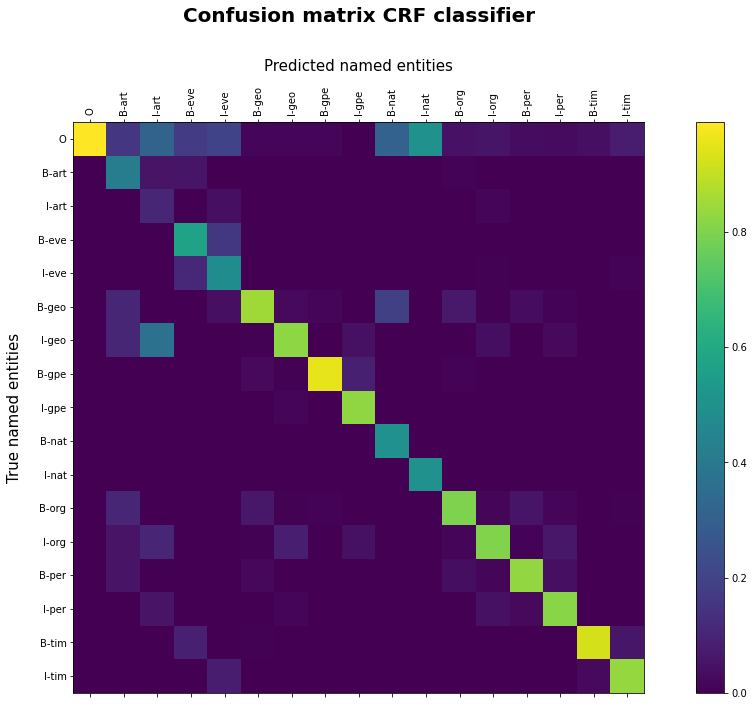

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

flat_list_test = [item for sublist in y_test for item in sublist]
flat_list_pred = [item for sublist in y_pred for item in sublist]


sortedLabels = ['O','B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe','I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per','B-tim','I-tim']
cm = confusion_matrix(flat_list_test, flat_list_pred, labels=sortedLabels, normalize='pred')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix CRF classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(sortedLabels)), sortedLabels, rotation=90)
plt.yticks(range(len(sortedLabels)), sortedLabels)
plt.show()
